
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

# Import, Wrangle, Split #

In [36]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders  # ==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Download the data
column_html = !curl https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
raw_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00211/CommViolPredUnnormalizedData.txt'

In [37]:
# A UCI dataset for predicting crime rates (Unnormalized)
# https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

import re
import pandas as pd

# Extract a list of column names and descriptions from the dataset's main webpage
# include "<br>  -- state: US state (by 2 letter postal abbreviation)(nominal)"
# include "<br>  -- householdsize: mean people per household (numeric - decimal)"
# avoid "<br>  -- Donor: Michael Redmond (redmond 'at' lasalle.edu); Computer Science; La Salle University; Philadelphia, PA, 19141, USA"
matches = [re.match('^<br>  -- (\S+): (.+)\((string|nominal|numeric).+$', line) for line in column_html]
matches = list(filter(None, matches))  # filter out non-matches that are None
column_names = [match.group(1) for match in matches]
column_descriptions = {match.group(1) : match.group(2).rstrip() for match in matches}

df = pd.read_csv(raw_data, names = column_names, na_values=['?'])
df.head()

,communityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.0,NaN,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,3217.7,3.31,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,1,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.0,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,974.2,0.38,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,NaN,NaN,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [41]:
for i, (name, descrip) in enumerate(column_descriptions.items()):
  print(i, name+' = "'+descrip+'"')
  if i == 5:
    break

0 communityname = "Community name - not predictive - for information only"
1 state = "US state (by 2 letter postal abbreviation)"
2 countyCode = "numeric code for county - not predictive, and many missing values"
3 communityCode = "numeric code for community - not predictive and many missing values"
4 fold = "fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive"
5 population = "population for community:"


In [40]:
# When a column is dropped from df, it also needs to be dropped in column_names and column_descriptions
# If column_name is not present, no errors are raised
def drop_column(column_name, data):
  # remove from the DataFrame
  data.drop(columns=[column_name], errors='ignore', inplace=True)

  # remove from the column_names list
  try:
    column_names.remove(column_name)
  except ValueError:
    # "that's nice dear"
    pass

  # remove from the column_descriptions dictionary
  column_descriptions.pop(column_name, None)

# drop_column('fold', df)

In [133]:
# Feature Engineering Time!

# Remove rows where my targets are null
# (turns out models don't like comparing their prediction to null)
good_rows = df[~(df.ViolentCrimesPerPop.isna() | df.nonViolPerPop.isna())]

unusable_columns = ['communityname', 'countyCode', 'communityCode', 'fold']
for name in unusable_columns:
  drop_column(name, good_rows)

# Remove the lemas columns. They 22 are columns on the size and structure of a police department
# but there are only observations for 343 communities, and 1872 missing observations.
lema_columns = [col for col in df.columns if df[col].isna().sum() == 1872]
for name in lema_columns:
  drop_column(name, good_rows)

# Create a smaller DataFrame (343,22) of just the lemas data
# May use for making better predicitons for these communities
# lemas = df[lema_columns]
# lemas = lemas[~df.LemasSwornFT.isna()]

# Finally split the columns up
# The final columns are all various crime rates
features = good_rows[column_names[:column_names.index('LemasPctOfficDrugUn')+1]]
y_v = good_rows['ViolentCrimesPerPop']
y_nv = good_rows['nonViolPerPop']

# If I want to expand to a true multiclass regression problem
# targets = good_rows[column_names[column_names.index('LemasPctOfficDrugUn'):]]


print('Features', features.shape)
# print('Lemas', lemas.shape)
# print('Targets', targets.shape)
print('ViolentCrimesPerPop', y_v.shape)
print('nonViolPerPop', y_nv.shape)

Features (1902, 103)
ViolentCrimesPerPop (1902,)
nonViolPerPop (1902,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [135]:
# Features
print('Features', features.shape)
display(features.head())

# Lemas
# print('\nLemas', lemas.shape)
# display(lemas.head())

# Target
# print('\nTargets', targets.shape)
# display(targets.head())

Features (1902, 103)


,state,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,...,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,NJ,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,...,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.0
1,PA,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,...,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.0
2,OR,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,...,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.0
5,MO,140494,2.45,2.51,95.65,0.90,0.95,18.09,32.89,20.04,13.26,140494,100.0,21577,75.78,1.00,41.15,29.31,7.12,14.09,27705,11878,12029,7382,10264,10753,7192.0,8104,23223,17.78,8.76,23.03,20.66,5.72,59.02,14.31,26.83,14.72,23.42,11.40,...,3.08,1.92,2.28,2.37,2.16,57.81,2.11,53.19,2,5119,91.81,55.50,2.09,26.22,1966,6.13,0.31,37700,53900,73100,35400,215,280,349,134,340,26.4,17.3,11.7,327,4,1.49,64.35,42.29,70.61,85.66,70.4,1995.7,0.97,0.0
6,MA,28700,2.60,1.60,96.57,1.47,1.10,11.17,27.41,12.76,14.42,28700,100.0,42805,79.47,0.39,47.70,30.23,5.41,17.23,50394,18193,18276,17342,21482,12639,21852.0,22594,1126,4.01,4.49,13.89,27.01,4.85,65.42,14.02,27.17,8.50,32.78,5.97,...,5.08,3.46,2.55,2.89,2.09,64.62,1.47,47.35,3,566,95.11,56.96,1.41,34.45,1956,0.69,0.28,155100,179000,215500,60400,463,669,824,361,736,24.4,20.8,12.5,0,0,9.19,77.30,63.45,82.23,93.53,10.9,2643.5,9.62,0.0


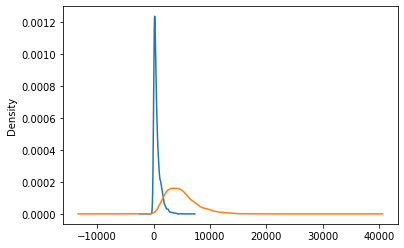

In [136]:
# What's the distributions of my targets?
y_v.plot.density()
y_nv.plot.density()

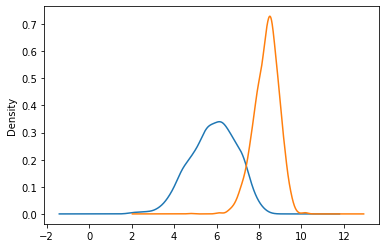

In [137]:
# Transform the targets into more normal distributions
import numpy as np
y_v_log = np.log(y_v)
y_nv_log = np.log(y_nv)

y_v_log.plot.density()
y_nv_log.plot.density()

In [138]:
# Split the data
from sklearn.model_selection import train_test_split

# Split the training/val and test data
X_trainval, X_test, \
y_v_trainval_log, y_v_test_log, \
y_nv_trainval_log, y_nv_test_log \
    = train_test_split(
        features,
        y_v_log,
        y_nv_log,
        test_size=0.2,
        random_state=42,
        )

# Split the training and validation data
X_train, X_val, \
y_v_train_log, y_v_val_log, \
y_nv_train_log, y_nv_val_log \
    = train_test_split(
        X_trainval,
        y_v_trainval_log,
        y_nv_trainval_log,
        train_size = 0.8,
        random_state = 42,
        )

print('Shapes')
print('X_train,        X_val,        X_test        ', X_train.shape, X_val.shape, X_test.shape)
print('y_v_train_log,  y_v_val_log,  y_v_test_log  ', y_v_train_log.shape, y_v_val_log.shape, y_v_test_log.shape)
print('y_nv_train_log, y_nv_val_log, y_nv_test_log ', y_nv_train_log.shape, y_nv_val_log.shape, y_nv_test_log.shape)

Shapes
X_train,        X_val,        X_test         (1216, 103) (305, 103) (381, 103)
y_v_train_log,  y_v_val_log,  y_v_test_log   (1216,) (305,) (381,)
y_nv_train_log, y_nv_val_log, y_nv_test_log  (1216,) (305,) (381,)


# Predicting Violent Crime Rates #

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Random Forest Validation R^2 0.6462670198953613


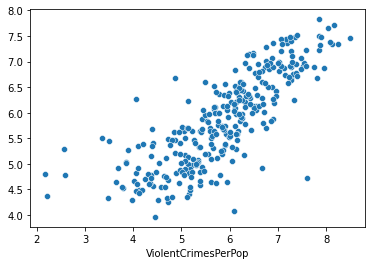

In [141]:
# 1 of 4 RFV - Random Forest model prediction Violence
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

rfv = make_pipeline(
    ce.OrdinalEncoder(cols=['state']),
    RandomForestRegressor(n_estimators=100, n_jobs=-1),
    )
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

rfv.fit(X_train, y_v_train_log)
y_rfv_pred_log = rfv.predict(X_val)
print('Random Forest Validation R^2', r2_score(y_v_val_log, y_rfv_pred_log))

sns.scatterplot(x=y_v_val_log, y=y_rfv_pred_log);

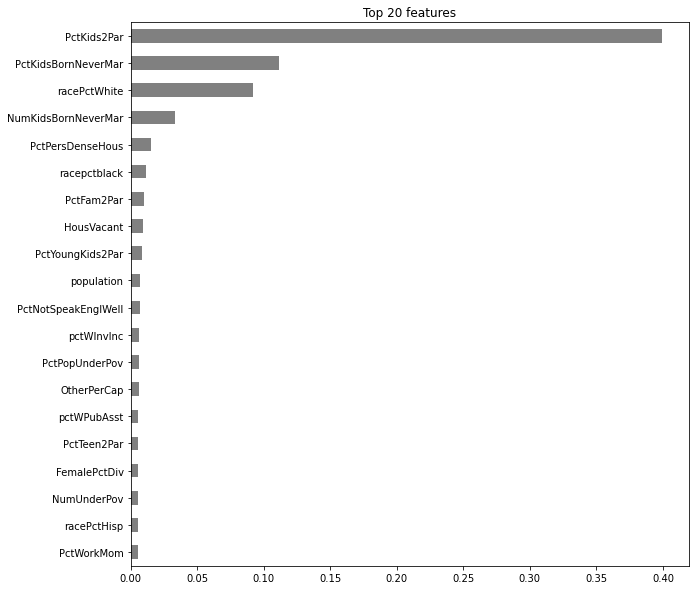

In [142]:
# Get feature importances
rf = rfv.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
# %matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Gradient Boosting Validation R^2 0.6573093084462489


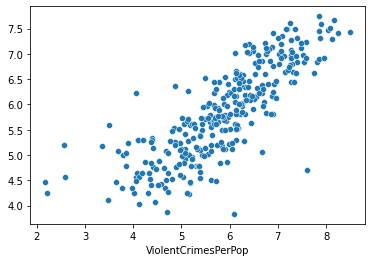

In [143]:
# 2 of 4 GBV - XGBoost model predicting Violence
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import seaborn as sns

gbv = make_pipeline(
    ce.OrdinalEncoder(cols=['state']), 
    XGBRegressor(n_estimators=100, objective='reg:squarederror', n_jobs=-1)
)

gbv.fit(X_train, y_v_train_log)
y_gbv_pred_log = gbv.predict(X_val)
print('Gradient Boosting Validation R^2', r2_score(y_v_val_log, y_gbv_pred_log))

sns.scatterplot(x=y_v_val_log, y=y_gbv_pred_log);

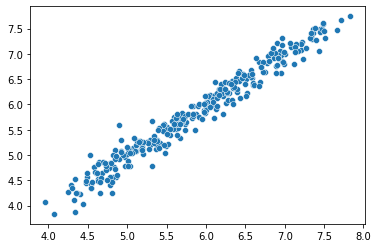

In [144]:
# How much the random forest and xgboost models agree with each other on violent crime
sns.scatterplot(x=y_rfv_pred_log, y=y_gbv_pred_log);

# Predicting Non-Violent Crime Rates #

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Random Forest Validation R^2 0.5306653455276951


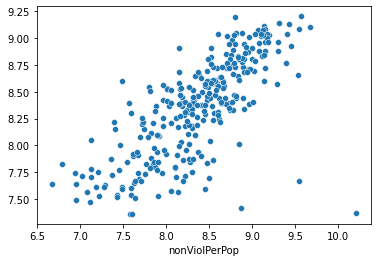

In [147]:
# 3 of 4 RFNV - Random Forest model prediction Non Violent Crime
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor

rfnv = make_pipeline(
    ce.OrdinalEncoder(cols=['state']),
    RandomForestRegressor(n_estimators=100, n_jobs=-1),
    )
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

rfnv.fit(X_train, y_nv_train_log)
y_rfnv_pred_log = rfnv.predict(X_val)
print('Random Forest Validation R^2', r2_score(y_nv_val_log, y_rfnv_pred_log))

sns.scatterplot(x=y_nv_val_log, y=y_rfnv_pred_log);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Gradient Boosting Validation R^2 0.525428706939004


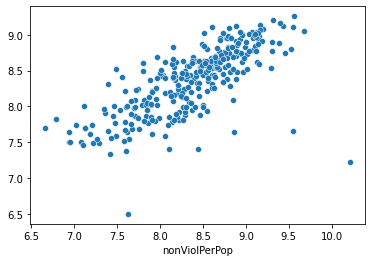

In [148]:
# 4 of 4 GBNV - XGBoost model predicting Non Violent Crimes
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import seaborn as sns

gbnv = make_pipeline(
    ce.OrdinalEncoder(cols=['state']), 
    XGBRegressor(n_estimators=100, objective='reg:squarederror', n_jobs=-1)
)

gbnv.fit(X_train, y_nv_train_log)
y_gbnv_pred_log = gbnv.predict(X_val)
print('Gradient Boosting Validation R^2', r2_score(y_nv_val_log, y_gbnv_pred_log))

sns.scatterplot(x=y_nv_val_log, y=y_gbnv_pred_log);

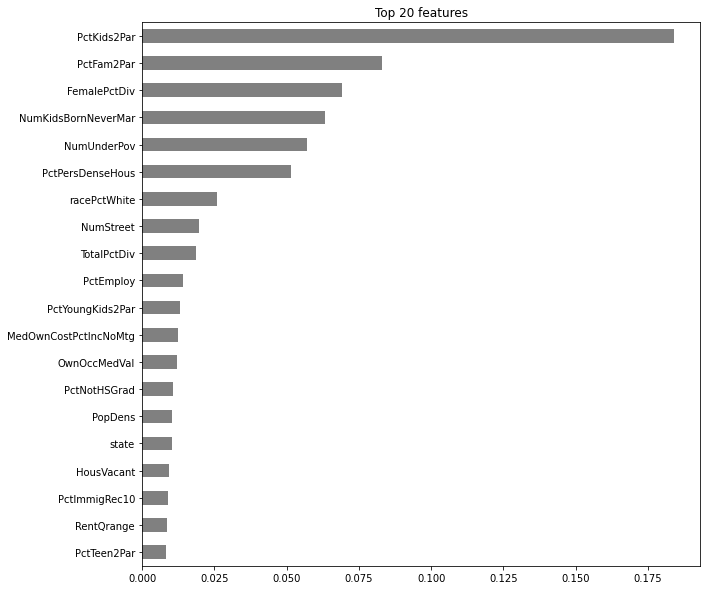

In [149]:
# Get feature importances
gb = gbnv.named_steps['xgbregressor']
importances = pd.Series(gb.feature_importances_, X_train.columns)

# Plot feature importances
# %matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [ ]:
# Untransform the target predictions back
y_pred_unlog = np.e**y_pred

In [ ]:
# I iteratively ran this over and over at n_iter=15, and did the following steps
# 1. Take the model parameters from the best 3 models from search.cv_results_
# 2. Adjust param_distributions with the min and max of the top 3 models
# 3. Run again and repeat until the parameters are in a narrow range.

from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

rf = make_pipeline(
    OrdinalEncoder(cols=['state']),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(),
    )

hypers = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__ccp_alpha': [0.0],
    'randomforestregressor__criterion': ['mse'],
    'randomforestregressor__max_depth': randint(2, 80),
    'randomforestregressor__max_features': ['auto'],
    'randomforestregressor__max_leaf_nodes': [None],
    'randomforestregressor__max_samples': [None],
    'randomforestregressor__min_impurity_decrease': [0.0],
    'randomforestregressor__min_impurity_split': [None],
    'randomforestregressor__min_samples_leaf': [1],
    'randomforestregressor__min_samples_split': [2],
    'randomforestregressor__min_weight_fraction_leaf': [0.0],
    'randomforestregressor__n_estimators': randint(2, 100),
    'randomforestregressor__n_jobs': [None],
    'randomforestregressor__oob_score': [False],
    'randomforestregressor__random_state': [None],
    'randomforestregressor__verbose': [0],
}
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    rf,
    param_distributions = hypers, 
    n_iter=1, 
    cv=3,
    scoring='r2', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

search.fit(X_train, y_train);

best_model = search.best_estimator_
print('Validation R^2', best_model.score(X_val, y_val))
# print(search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Validation R^2 0.6409521818843574
{'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0.0, 'randomforestregressor__criterion': 'mse', 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__max_samples': None, 'randomforestregressor__min_impurity_decrease': 0.0, 'randomforestregressor__min_impurity_split': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_weight_fraction_leaf': 0.0, 'randomforestregressor__n_estimators': 68, 'randomforestregressor__n_jobs': None, 'randomforestregressor__oob_score': False, 'randomforestregressor__random_state': None, 'randomforestregressor__verbose': 0}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  7

[04:13:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters = {'xgbregressor__base_score': 9.862023579333515, 'xgbregressor__booster': 'dart', 'xgbregressor__max_depth': 7, 'xgbregressor__n_estimators': 466}
Gradient Boosting Validation R^2 0.6300466449746361
CPU times: user 21.4 s, sys: 355 ms, total: 21.7 s
Wall time: 25min 3s


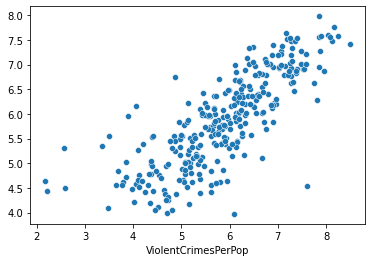

In [176]:
%%time
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

gbp = make_pipeline(
    ce.OrdinalEncoder(cols=['state']), 
    XGBRegressor()
)

# base_score = y_v_train_log.median()
# 5.911230130916153
target = y_v_train_log

xgbregressor_full = {
  'xgbregressor__base_score': uniform(target.min(), target.max()),
  'xgbregressor__booster': ['gbtree','gblinear','dart'],
  # 'xgbregressor__colsample_bylevel': [1],
  # 'xgbregressor__colsample_bynode': [1],
  # 'xgbregressor__colsample_bytree': [1],
  # 'xgbregressor__gamma': [0],
  # 'xgbregressor__importance_type': ['gain'],
  # 'xgbregressor__learning_rate': uniform(1,5),
  # 'xgbregressor__max_delta_step': [0],
  'xgbregressor__max_depth': randint(2, 500),
  # 'xgbregressor__min_child_weight': [1],
  # 'xgbregressor__missing': [None],
  'xgbregressor__n_estimators': randint(2, 500),
  # 'xgbregressor__n_jobs': [-1],
  # 'xgbregressor__nthread': [None],
  # 'xgbregressor__objective': ['reg:squarederror'],
  # 'xgbregressor__random_state': [42],
  # 'xgbregressor__reg_alpha': [0],
  # 'xgbregressor__reg_lambda': [1],
  # 'xgbregressor__scale_pos_weight': [1],
  # 'xgbregressor__seed': [None],
  # 'xgbregressor__silent': [None],
  # 'xgbregressor__subsample': [1],
  # 'xgbregressor__verbosity': [1],
}
hypers = {
  'xgbregressor__base_score': uniform(loc=9, scale=6),
  'xgbregressor__booster': ['gbtree','gblinear','dart'],
  # 'xgbregressor__colsample_bylevel': [1],
  # 'xgbregressor__colsample_bynode': [1],
  # 'xgbregressor__colsample_bytree': [1],
  # 'xgbregressor__gamma': [0],
  # 'xgbregressor__importance_type': ['gain'],
  # 'xgbregressor__learning_rate': uniform(1,5),
  # 'xgbregressor__max_delta_step': [0],
  'xgbregressor__max_depth': randint(2, 500),
  # 'xgbregressor__min_child_weight': [1],
  # 'xgbregressor__missing': [None],
  'xgbregressor__n_estimators': randint(2, 500),
  # 'xgbregressor__n_jobs': [-1],
  # 'xgbregressor__nthread': [None],
  # 'xgbregressor__objective': ['reg:squarederror'],
  # 'xgbregressor__random_state': [42],
  # 'xgbregressor__reg_alpha': [0],
  # 'xgbregressor__reg_lambda': [1],
  # 'xgbregressor__scale_pos_weight': [1],
  # 'xgbregressor__seed': [None],
  # 'xgbregressor__silent': [None],
  # 'xgbregressor__subsample': [1],
  # 'xgbregressor__verbosity': [1],
}
# https://xgboost.readthedocs.io/en/latest/python/python_api.html

# If you're on Colab, decrease n_iter & cv parameters
gbs = RandomizedSearchCV(
    gbp,
    param_distributions = hypers, 
    n_iter=100, 
    cv=5,
    scoring='r2', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

gbs.fit(X_train, y_v_train_log)

print('Best parameters =',gbs.best_params_)

best_model = gbs.best_estimator_
y_gbv_pred_log = best_model.predict(X_val)
sns.scatterplot(x=y_v_val_log, y=y_gbv_pred_log);
print('Gradient Boosting Validation R^2', r2_score(y_v_val_log, y_gbv_pred_log))


In [177]:
pd.DataFrame(gbs.cv_results_).sort_values(by='rank_test_score').T  # mean_test_score, mean_fit_time

,60,58,68,97,18,40,83,89,28,53,24,16,5,79,30,84,64,41,54,27,87,95,35,4,88,49,44,2,21,94,73,20,92,8,66,81,99,69,6,57,...,14,29,78,47,34,59,96,65,98,3,33,62,25,46,86,56,75,32,43,13,85,48,50,61,26,39,31,93,80,42,7,23,38,90,10,71,12,91,63,70
mean_fit_time,17.1626,13.0697,7.0299,14.971,6.87915,7.97107,2.73922,6.45101,7.79598,5.92326,7.45471,7.18686,16.2758,6.32034,7.03,7.73521,7.03531,7.25505,7.21936,7.16597,7.3336,8.56964,6.87464,15.0286,16.5547,15.1405,7.86281,6.67994,2.1513,6.86483,4.21172,7.2314,6.96349,8.88764,7.162,4.56455,6.60702,8.56496,10.476,7.67799,...,0.712117,7.2172,18.496,0.946391,8.0877,6.29219,0.779598,18.1114,0.535389,0.485373,0.641443,14.7676,0.461433,0.627785,7.45484,0.515255,1.58411,0.716004,0.37164,7.82718,0.545162,0.419284,0.284204,0.497515,0.317534,0.443464,0.224963,0.456806,0.468316,0.369628,0.34414,0.395278,1.23047,0.237813,0.106471,0.16726,0.122424,0.0353408,0.159974,0.094384
std_fit_time,0.225768,0.7327,0.449142,0.37437,0.313644,0.389872,0.0816899,0.0777463,0.420021,0.190383,0.278694,0.427676,0.523384,0.192512,0.256216,0.199749,0.319258,0.30965,0.216022,0.419724,0.324272,0.238809,0.285711,0.49879,0.783075,0.336701,0.503645,0.455943,0.0355915,0.433154,0.0862101,0.281816,0.211771,0.369127,0.202422,0.139295,0.973209,0.220746,0.535666,0.378751,...,0.00816705,0.424357,0.348056,0.0103976,0.206876,0.44312,0.0221585,0.425189,0.00591574,0.00768983,0.00243054,0.573082,0.0033007,0.00798068,0.376271,0.00854275,0.0307613,0.00845004,0.010298,0.456859,0.00652208,0.0111944,0.00290081,0.0051686,0.00558933,0.00810683,0.00584503,0.00599125,0.00776631,0.00522785,0.00517868,0.00801016,0.0162686,0.00915839,0.00188153,0.00422328,0.00501194,0.00253809,0.0040977,0.00222745
mean_score_time,0.015158,0.0139159,0.0135041,0.0141447,0.0135077,0.0140524,0.0095386,0.0133206,0.0142175,0.0129595,0.0137798,0.0135436,0.0139975,0.0130801,0.0133376,0.0129035,0.0137216,0.013333,0.0170222,0.0135809,0.014039,0.0133699,0.0136583,0.0144459,0.0160436,0.0148842,0.0139319,0.0145346,0.00902886,0.0138709,0.0119484,0.0136649,0.0135086,0.0131303,0.013848,0.0115621,0.0129787,0.013359,0.014171,0.0140224,...,0.00727429,0.0136556,0.0142172,0.00708752,0.0136162,0.0132468,0.00710063,0.014443,0.00710707,0.00752649,0.0070622,0.0144372,0.00706377,0.00905776,0.0136805,0.00701089,0.00868826,0.00717959,0.00742812,0.0138808,0.00712061,0.00702968,0.00710397,0.00697899,0.0069695,0.00707512,0.00707092,0.0072927,0.00711198,0.00696616,0.00754633,0.00735731,0.00809164,0.00719051,0.00700989,0.00703812,0.00706062,0.00659332,0.00718126,0.00694804
std_score_time,0.00042423,0.000587987,0.000315149,0.000418935,0.000315664,0.000366509,0.000228182,0.000307114,0.000919197,0.000265459,0.000269957,0.000215317,0.000440283,0.000142125,0.000307319,0.000415848,0.000498742,0.000276141,0.00533714,0.000510032,0.000642357,0.000211134,0.000592885,0.00082401,0.00327975,0.000937996,0.000368387,0.00230953,0.000146474,0.000296474,0.00250081,0.000274245,0.000552148,0.00019643,0.000535123,0.000769026,0.00149662,0.000261693,0.000572952,0.000411174,...,0.000304436,0.000480925,0.000405833,0.000238428,0.000107907,0.000516561,9.31875e-05,0.00072991,7.84523e-05,0.000841693,0.000127499,0.000728597,5.03072e-05,0.00298273,0.000286536,0.000122527,0.000367568,0.000124659,0.000520209,0.000600126,0.000169924,0.000155138,0.000148877,7.51717e-05,0.000102572,0.000253905,7.62305e-05,0.000480947,0.000142695,6.85123e-05,0.000833927,8.56507e-05,0.000136762,0.00015302,3.47747e-05,8.81992e-05,0.000146842,0.000134645,0.000132574,0.00012249
param_xgbregressor__base_score,9.86202,14.2,12.46,11.6608,11.6917,12.2269,14.2212,9.63145,13.3202,10.2483,13.5616,12.2459,9.65877,11.5092,12.3853,12.2388,11.2326,9.81469,14.7404,14.2664,13.1763,10.78,12.0216,14.3933,10.9387,10.1347,11.2123,11.0968,12.4869,14.3847,9.44096,10.0847,9.01729,9.61346,12.5482,11.5911,11.8616,9.62206,10.0829,14.3469,...,11.2845,10.3559,9.37678,13.7687,14.8781,9.58147,12.3766,12.1625,10.7876,10.2258,12.0044,11.1167,10.5103,12.297,12.1262,11.4739,10.2387,14.0575,

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    best_model,
    scoring = 'neg_mean_absolute_error',
    n_iter=5,
    random_state = 42
)
encoder = OrdinalEncoder(cols=['state'])
X_encoded = encoder.fit_transform(X_train)
permuter.fit(X_encoded, y_train)

In [ ]:
best_model.score(X_test, y_test)

In [ ]:
eli5.show_weights(
    permuter,
    top = None, # no limit
    feature_names = X_train.columns.to_list() # must be a list
)